In [1]:
from sklearn.metrics.cluster import adjusted_rand_score, v_measure_score, silhouette_score
import numpy as np  
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import Birch, AgglomerativeClustering, KMeans, DBSCAN, MiniBatchKMeans
from sklearn.datasets import make_blobs, make_moons, load_iris, load_digits
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
import time
from joblib import cpu_count
#import gower
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mode
%matplotlib inline

# Porównanie i ocena algorytmów grupowania 

### Przykład 1: miary ARI, V-measure i współczynnik sylwetki dla danych two moons

Dla danych two moons porównaj grupowanie k-średnich, aglomeracyjne i DBSCAN przy użyciu ARI, V-measure i współczynnika sylwetki. 
Porównaj wyniki także z losowym przypisaniem punktów do dwóch klastrów. Zwizualizuj wyniki.

In [2]:
X, y = make_moons(n_samples = 200, noise = .05, random_state = 7)
# skalownie danych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

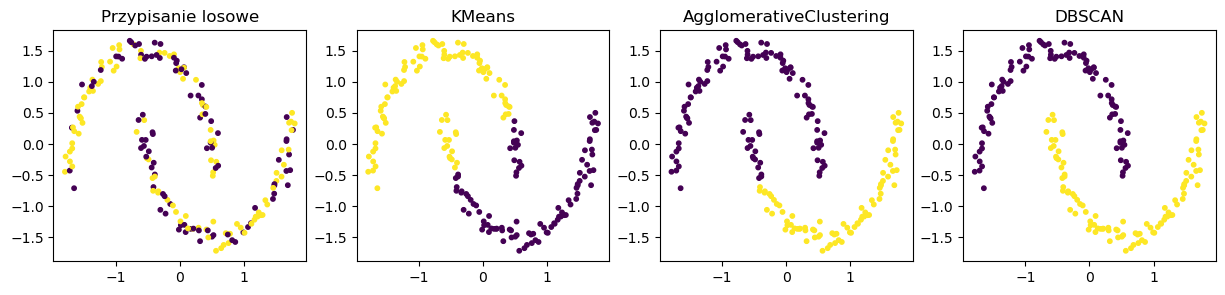

In [3]:
fig, axes = plt.subplots(1, 4, figsize = (15,3))
algorithms = [KMeans(n_clusters = 2, n_init = 10), AgglomerativeClustering(n_clusters = 2), DBSCAN()]
# losowe przypisanie:
random_state = np.random.RandomState(seed = 7)
random_clusters = random_state.randint(low = 0, high = 2, size = len(X)) # 0 i 1
axes[0].scatter(X_scaled[:,0], X_scaled[:,1], c = random_clusters, s = 10)
axes[0].set_title("Przypisanie losowe")
indeksy = pd.DataFrame(columns=['Przypisanie losowe', 'KMeans', 'AgglomerativeClustering', 'DBSCAN'], index = ['ARI', 'V-measure', 'silhouette score'])
indeksy['Przypisanie losowe'] = [adjusted_rand_score(y, random_clusters), v_measure_score(y, random_clusters), silhouette_score(X_scaled, random_clusters)]
for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:,0], X_scaled[:,1], c = clusters, s = 10)
    alg_str = str(algorithm).split("(")[0]
    ax.set_title(alg_str)
    indeksy[alg_str] = [adjusted_rand_score(y, clusters), v_measure_score(y, clusters), silhouette_score(X_scaled, clusters)]


In [4]:
round(indeksy,2)

,Przypisanie losowe,KMeans,AgglomerativeClustering,DBSCAN
ARI,-0.0,0.47,0.65,1.00
V-measure,0.0,0.38,0.63,1.00
silhouette score,0.0,0.49,0.45,0.38


In [5]:
print(pd.crosstab(clusters, y))

col_0    0    1
row_0          
0      100    0
1        0  100


In [6]:
print(pd.crosstab(random_clusters, y))

col_0   0   1
row_0        
0      44  50
1      56  50


### Ćwiczenie 1: miary ARI i V-measure dla danych Irysy

Dla danych Irysy porównaj grupowania znalezione przez algorytmy grupowania k-średnich i aglomeracyjne
za pomocą indeksu ARI i V-measure. Zwizualiuj wyniki.

In [7]:
iris = load_iris()
y = iris.target
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [8]:
np.bincount(y)

array([50, 50, 50])

In [9]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [10]:
X_scaled = StandardScaler().fit_transform(iris.data) 

In [11]:
indeksy = pd.DataFrame(columns=['KMeans', 'AgglomerativeClustering complete', 'AgglomerativeClustering ward'], index = ['ARI', 'V-measure'])

In [12]:
model = KMeans(n_clusters = 3, n_init = 10, random_state = 7)
model.fit(X_scaled)
labels = model.labels_ 
indeksy['KMeans'] = [adjusted_rand_score(y, labels), v_measure_score(y, labels)]

In [13]:
L1 = linkage(X_scaled, method='complete', metric='euclidean')
L4 = linkage(X_scaled, method='ward', metric='euclidean')

In [14]:
clust1 = fcluster(L1, 3, criterion='maxclust')
clust4 = fcluster(L4, 2, criterion='maxclust')

In [15]:
indeksy['AgglomerativeClustering complete'] = [adjusted_rand_score(y, clust1), v_measure_score(y, clust1)]
indeksy['AgglomerativeClustering ward'] = [adjusted_rand_score(y, clust4), v_measure_score(y, clust4)]

In [16]:
round(indeksy, 2)

,KMeans,AgglomerativeClustering complete,AgglomerativeClustering ward
ARI,0.59,0.57,0.54
V-measure,0.64,0.65,0.69


In [17]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)

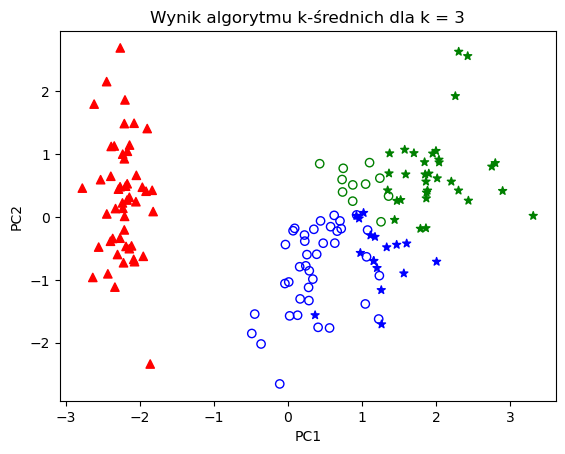

In [20]:
plt.scatter(X_pca[y == 0,0], X_pca[y == 0,1], c = np.array(['red', 'blue', 'green'])[np.array(labels[y == 0])], marker = '^')
plt.scatter(X_pca[y == 1,0], X_pca[y == 1,1], edgecolors = np.array(['red', 'blue', 'green'])[np.array(labels[y == 1])], marker = 'o', facecolors = 'none')
plt.scatter(X_pca[y == 2,0], X_pca[y == 2,1], c = np.array(['red', 'blue', 'green'])[np.array(labels[y == 2])], marker = '*')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Wynik algorytmu k-średnich dla k = 3")
plt.show()

In [21]:
print(pd.crosstab(labels, y))

col_0   0   1   2
row_0            
0      50   0   0
1       0  39  17
2       0  11  33


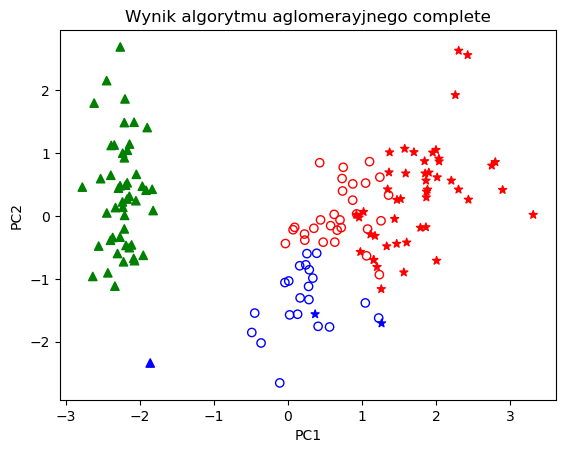

In [22]:
plt.scatter(X_pca[y == 0,0], X_pca[y == 0,1], c = np.array(['red', 'blue', 'green'])[np.array(clust1[y == 0])-1], marker = '^')
plt.scatter(X_pca[y == 1,0], X_pca[y == 1,1], edgecolors = np.array(['red', 'blue', 'green'])[np.array(clust1[y == 1])-1], marker = 'o', facecolors = 'none')
plt.scatter(X_pca[y == 2,0], X_pca[y == 2,1], c = np.array(['red', 'blue', 'green'])[np.array(clust1[y == 2])-1], marker = '*')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Wynik algorytmu aglomerayjnego complete")
plt.show()

In [23]:
print(pd.crosstab(clust1, y))

col_0   0   1   2
row_0            
1       0  29  48
2       1  21   2
3      49   0   0


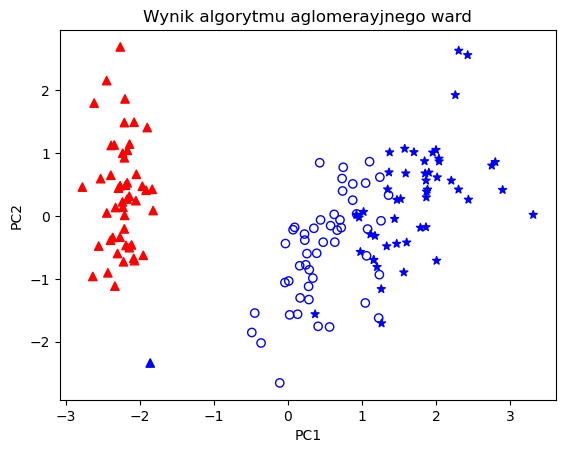

In [24]:
plt.scatter(X_pca[y == 0,0], X_pca[y == 0,1], c = np.array(['red', 'blue', 'green'])[np.array(clust4[y == 0])-1], marker = '^')
plt.scatter(X_pca[y == 1,0], X_pca[y == 1,1], edgecolors = np.array(['red', 'blue', 'green'])[np.array(clust4[y == 1])-1], marker = 'o', facecolors = 'none')
plt.scatter(X_pca[y == 2,0], X_pca[y == 2,1], c = np.array(['red', 'blue', 'green'])[np.array(clust4[y == 2])-1], marker = '*')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Wynik algorytmu aglomerayjnego ward")
plt.show()

In [25]:
print(pd.crosstab(clust4, y))

col_0   0   1   2
row_0            
1      49   0   0
2       1  50  50


Możemy też policzyć podobieńsywa pomiędzy grupowaniami, np. k-średnich i aglomeracyjnym!

In [26]:
adjusted_rand_score(clust1, labels)

0.559377230043409

In [27]:
v_measure_score(clust1, labels)

0.683147425281484

# Grupowanie danych mieszanych

### Przykład 2: grupowanie danych mieszanych blobs za pomocą kodowania binarnego zmiennych kategorialnych

Dla danych blobs zakoduj zmienną kategorialną za pomocą zmiennych binarnych i zgrupuj dane za pomocą 
klateryzacji k-średnich z liczbą klastrów równą 3. Policz ARI i porównaj wynik klasteryzacji do klasteryzacji 
k-średnich tylko na zmiennych ciągłych.  

In [81]:
X, y = make_blobs(n_samples = 100, centers = 3, n_features = 3, center_box=[-6, 6], random_state = 1234)
X = pd.DataFrame(X, columns=['X1', 'X2', 'X3'])
X['X3'] = np.where(X['X3'] < -2, 'LOW', np.where(X['X3'] > 2, 'HIGH', 'MEDIUM'))
con = ['X1', 'X2'] 
cat = ['X3']
scale = StandardScaler()
X[con] = scale.fit_transform(X[con])
display(X.head())

,X1,X2,X3
0,-0.953471,-2.206143,MEDIUM
1,-0.450817,1.346499,HIGH
2,-0.998503,-0.415265,MEDIUM
3,1.770144,0.982478,LOW
4,-0.538918,-1.409679,HIGH


In [82]:
X['X3'].value_counts()

MEDIUM    41
HIGH      33
LOW       26
Name: X3, dtype: int64

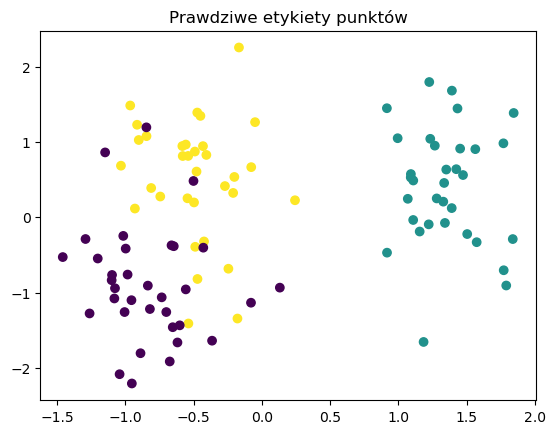

In [83]:
plt.scatter(X['X1'], X['X2'], c = y)
plt.title("Prawdziwe etykiety punktów")
plt.show()

In [84]:
X_dum = pd.get_dummies(X, drop_first=True)
X_dum

,X1,X2,X3_LOW,X3_MEDIUM
0,-0.953471,-2.206143,0,1
1,-0.450817,1.346499,0,0
2,-0.998503,-0.415265,0,1
3,1.770144,0.982478,1,0
4,-0.538918,-1.409679,0,0
...,...,...,...,...
95,-1.098665,-0.765337,0,1
96,-0.583274,0.946393,0,0
97,-0.734585,-1.062558,0,1
98,-0.407255,0.828192,0,0


In [85]:
cat = ['X3_LOW', 'X3_MEDIUM']

In [86]:
scale = StandardScaler()
X_dum[cat] = scale.fit_transform(X_dum[cat])

In [87]:
X_dum.describe()

,X1,X2,X3_LOW,X3_MEDIUM
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,1.110223e-17,1.966483e-16,1.332268e-17,7.993606e-17
std,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00
min,-1.459820e+00,-2.206143e+00,-5.927490e-01,-8.336158e-01
25%,-8.248834e-01,-8.227341e-01,-5.927490e-01,-8.336158e-01
50%,-4.615716e-01,1.599586e-01,-5.927490e-01,-8.336158e-01
75%,1.121187e+00,8.365352e-01,1.687055e+00,1.199593e+00
max,1.845405e+00,2.254838e+00,1.687055e+00,1.199593e+00


In [88]:
model = KMeans(n_clusters = 3, random_state = 7, n_init = 10)
model.fit(X_dum)
labels = model.labels_

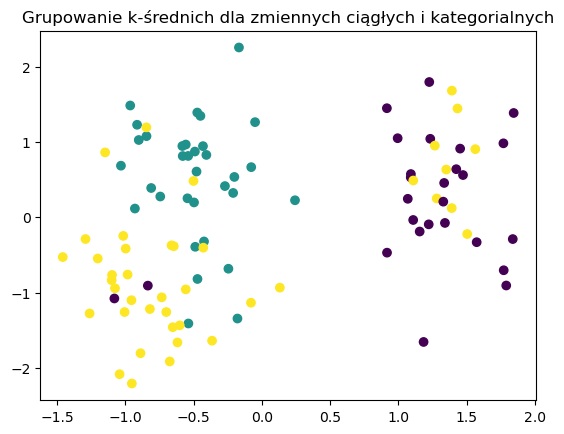

In [89]:
plt.scatter(X['X1'], X['X2'], c = labels)
plt.title("Grupowanie k-średnich dla zmiennych ciągłych i kategorialnych")
plt.show()

In [37]:
adjusted_rand_score(labels, y)

0.719614257190195

In [38]:
model2 = KMeans(n_clusters = 3, random_state = 7, n_init = 10)
model2.fit(X[['X1','X2']])
labels2 = model2.labels_

In [39]:
adjusted_rand_score(labels2, y)

0.7293278537362832

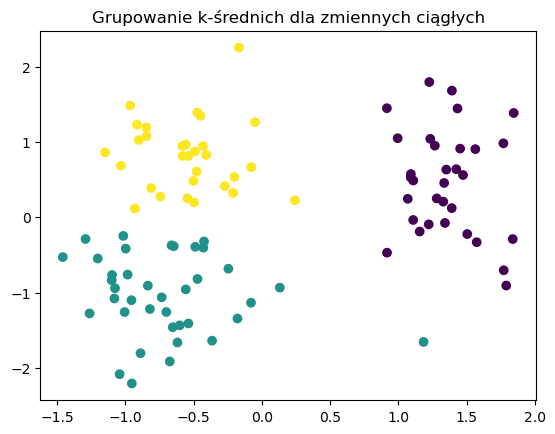

In [42]:
plt.scatter(X['X1'], X['X2'], c = labels2)
plt.title("Grupowanie k-średnich dla zmiennych ciągłych")
plt.show()

### Ćwiczenie 2: grupowanie danych mieszanych heart za pomocą kodowania binarnego zmiennych kategorialnych

Dla danych heart zakoduj zmienne kategorialne za pomocą zmiennych binarnych i zgrupuj dane za pomocą 
klateryzacji k-średnich z liczbą klastrów równą 2. Policz ARI i porównaj wynik klasteryzacji do klasteryzacji 
k-średnich tylko na zmiennych ciągłych. Zaprezentuj wyniki lepszej metody na wykresie.

In [90]:
heart = pd.read_csv("heart.csv")

Zbiór danych Cleveland Heart Disease pochodzi z repozytorium UCI machine learning. Zawiera 13 zmiennych, z czego 5 numerycznych i 8 kategorialnych. Liczba pacjentów jest równa 303, zmienną objaśnianą jest binarna zmienna mówiąca o obecności choroby serca. Kolumna target będzie nam służyła do oceny jakości grupowań.
https://archive.ics.uci.edu/ml/datasets/heart+disease

In [91]:
heart.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [92]:
y = heart['target']

In [93]:
cat = ['sex', 'cp', 'fbs','restecg', 'exang', 'slope', 'ca', 'thal']
con = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [94]:
cat_heart = pd.concat([pd.get_dummies(heart[col], drop_first=True, prefix=col) for col in cat], axis=1)

In [95]:
heart[cat].nunique()

sex        2
cp         4
fbs        2
restecg    3
exang      2
slope      3
ca         5
thal       4
dtype: int64

In [96]:
(heart[cat].nunique()-1).sum()

17

In [97]:
cat_heart.shape

(303, 17)

In [98]:
cat_heart.describe()

,sex_1,cp_1,cp_2,cp_3,fbs_1,restecg_1,restecg_2,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,0.683168,0.165017,0.287129,0.075908,0.148515,0.501650,0.013201,0.326733,0.462046,0.468647,0.214521,0.125413,0.066007,0.016502,0.059406,0.547855,0.386139
std,0.466011,0.371809,0.453171,0.265288,0.356198,0.500824,0.114325,0.469794,0.499382,0.499842,0.411169,0.331734,0.248704,0.127605,0.236774,0.498528,0.487668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [99]:
con_heart = heart[con]

In [100]:
heart_dum = pd.concat([con_heart, cat_heart], axis = 1)

In [101]:
heart_dum.shape

(303, 22)

In [102]:
heart_dum_scaled = scale.fit_transform(heart_dum)

In [103]:
model = KMeans(n_clusters = 2, random_state = 7, n_init = 10)
model.fit(heart_dum_scaled)
labels = model.labels_

In [104]:
adjusted_rand_score(labels, y)

0.3390602045488582

In [105]:
model1 = KMeans(n_clusters = 2, random_state = 7, n_init = 10)
model1.fit(heart_dum_scaled[:,:4])
labels1 = model1.labels_

In [106]:
adjusted_rand_score(labels1, y)

0.1265402869954581

In [107]:
pca = PCA(n_components = 2)
heart_pca = pca.fit_transform(heart_dum_scaled)

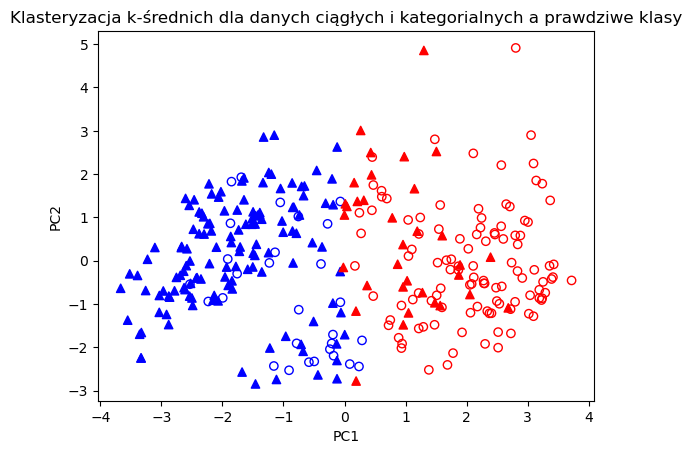

In [111]:
plt.scatter(heart_pca[y == 0,0], heart_pca[y == 0,1], edgecolors = np.array(["red", "blue"])[np.array(labels[y == 0])] , marker = 'o', facecolors = 'none')
plt.scatter(heart_pca[y == 1,0], heart_pca[y == 1,1], c = np.array(["red", "blue"])[np.array(labels[y == 1])] , marker = '^')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Klasteryzacja k-średnich dla danych ciągłych i kategorialnych a prawdziwe klasy")
plt.show()

# Grupowanie dużych danych

## Grupowanie Birch 

### Przykład 3: działanie algorytmu BIRCH i grupowania k-średnich na zbiorze danych blobs

Dla danych blobs zastosuj w pierwszym kroku algorytm BIRCH, a następnie klasteryzację 
k-średnich. Porównaj wyniki z klasteryzacją k-średnich bez wstępnego grupowania za pomocą BIRCH
oraz z grupowaniem BIRCH z zadaną liczbą klastrów. Sprawdź co się stanie jak w pierwszym kroku BIRCH wybierzesz threshold = 5. 

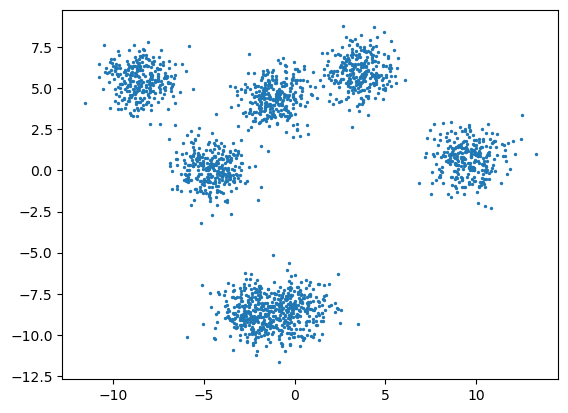

In [132]:
X = make_blobs(n_samples = 2000, centers = 7, random_state = 7)[0]
plt.scatter(X[:,0], X[:,1], s = 2)
plt.show()

#### BIRCH pierwszy krok

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html

In [133]:
model_birch = Birch(n_clusters = None) # If set to None, the final clustering step is not performed and the subclusters are returned as they are

In [134]:
model_birch.fit(X)
centers_birch = model_birch.subcluster_centers_
labels_birch = model_birch.labels_
centers_birch

array([[  0.13989748,  -7.8587729 ],
       [ -1.55881685,  -8.23796311],
       [ -2.13397776,  -9.93367662],
       [ -2.61796751,  -9.04716354],
       [  1.15620558,  -8.96248478],
       [ -0.31115701,  -9.22637743],
       [ -1.99629252,  -7.21606713],
       [  0.70728654,  -9.98137817],
       [ -1.34178902,  -9.26799824],
       [  1.09532875,  -7.3181144 ],
       [ -0.52433291,  -8.25442329],
       [ -4.34268501,  -8.72302257],
       [ -2.67584349,  -7.97990102],
       [ -0.97171975, -10.49078362],
       [ -3.50773086,  -8.61884144],
       [ -0.13218611, -10.19323276],
       [  0.9827522 ,  -8.20786618],
       [  3.52247837,  -9.33300656],
       [ -0.22135941,  -6.12204177],
       [ -4.18809374, -10.02033699],
       [ -0.61452704,  -7.31903298],
       [ -5.91553999, -10.14392553],
       [  2.14529563,  -6.59625435],
       [ -2.11293828, -11.11985467],
       [ -5.06480863,  -9.33901625],
       [ -2.84602932,  -6.87341177],
       [  2.30296608,  -8.49900891],
 

In [135]:
centers_birch.shape

(161, 2)

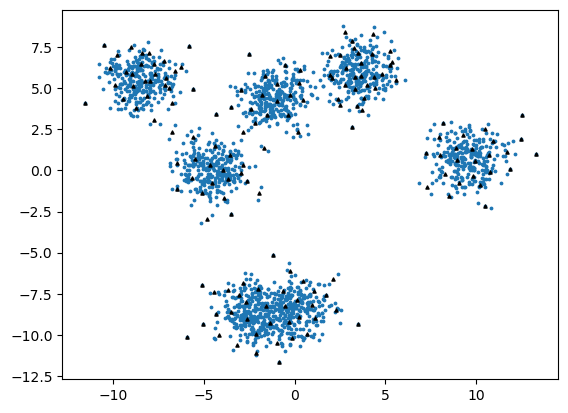

In [136]:
plt.scatter(X[:,0], X[:,1], s = 3)
plt.scatter(centers_birch[:,0], centers_birch[:,1], c = "black", marker = "^" , s = 5)
plt.show()

In [137]:
Xsmall = centers_birch

#### K-średnich drugi krok

In [138]:
wss = []
sil_score = []
for i in range(1, 15):
    model_kmeans = KMeans(n_clusters = i, n_init = 10, random_state = 7)
    model_kmeans.fit(Xsmall)
    wss.append(model_kmeans.inertia_)
    if i>1:
        sil_score.append(silhouette_score(Xsmall, model_kmeans.labels_))

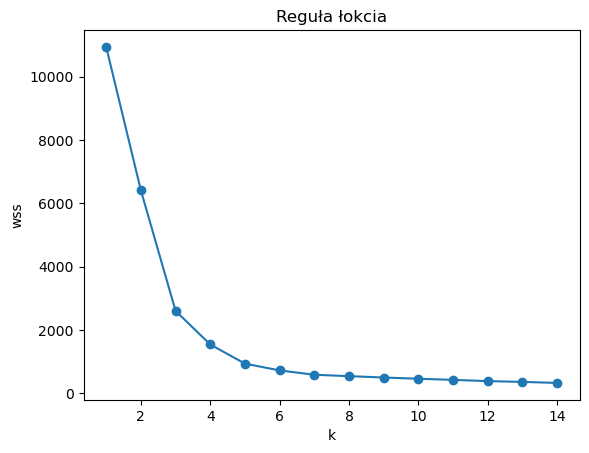

In [139]:
plt.plot(range(1, 15), wss, "-o")
plt.title("Reguła łokcia")
plt.xlabel("k")
plt.ylabel("wss")
plt.show()

In [140]:
kl = KneeLocator(range(1, 15), wss, curve="convex", direction="decreasing")
kl.elbow

4

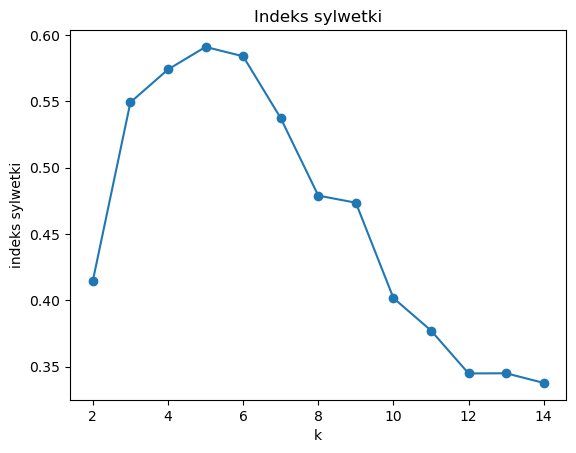

In [141]:
plt.plot(range(2, 15), sil_score, "-o")
plt.title("Indeks sylwetki")
plt.xlabel("k")
plt.ylabel("indeks sylwetki")
plt.show()

In [142]:
model_kmeans = KMeans(n_clusters = 5, n_init = 10, random_state = 7)
model_kmeans.fit(Xsmall)
centers_kmeans = model_kmeans.cluster_centers_
labels_kmeans = model_kmeans.labels_

In [143]:
labels_birch[:10]

array([ 35, 160,  37,   0,  83,  72, 111, 116,  97,  35])

In [144]:
labels_birch.shape

(2000,)

In [145]:
labels_kmeans[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [146]:
labels_kmeans.shape

(161,)

In [147]:
labels_fin = labels_kmeans[labels_birch]

In [148]:
np.bincount(labels_fin)

array([571, 458, 285, 286, 400])

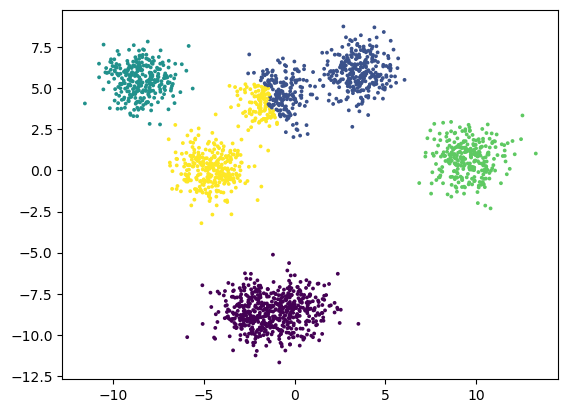

In [149]:
plt.scatter(X[:,0], X[:,1], c = labels_fin, s = 3)
plt.show()

In [150]:
model_birch2 = Birch(n_clusters=KMeans(5, n_init = 10, random_state = 7))
model_birch2.fit(X)

Birch(n_clusters=KMeans(n_clusters=5, n_init=10, random_state=7))

In [151]:
np.bincount(model_birch2.labels_)

array([571, 458, 285, 286, 400])

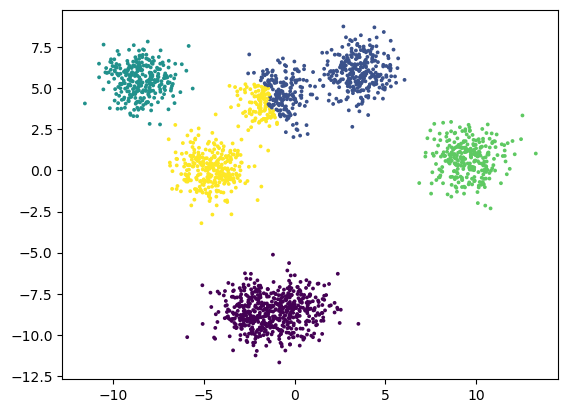

In [152]:
plt.scatter(X[:,0], X[:,1], c = model_birch2.labels_, s = 3)
plt.show()

#### K-średnich dla pełnych danych

In [153]:
wss2 = []
sil_score2 = []
for i in range(1, 15):
    model_kmeans2 = KMeans(n_clusters = i, n_init = 10, random_state = 7)
    model_kmeans2.fit(X)
    wss2.append(model_kmeans2.inertia_)
    if i>1:
        sil_score2.append(silhouette_score(X, model_kmeans2.labels_))

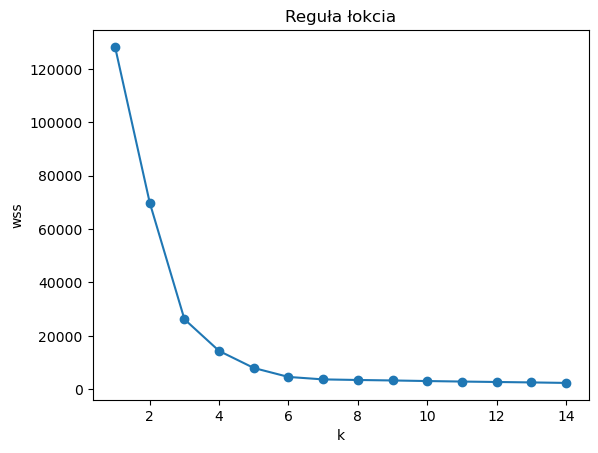

In [154]:
plt.plot(range(1, 15), wss2, "-o")
plt.title("Reguła łokcia")
plt.xlabel("k")
plt.ylabel("wss")
plt.show()

In [155]:
kl = KneeLocator(range(1, 15), wss2, curve="convex", direction="decreasing")
kl.elbow

4

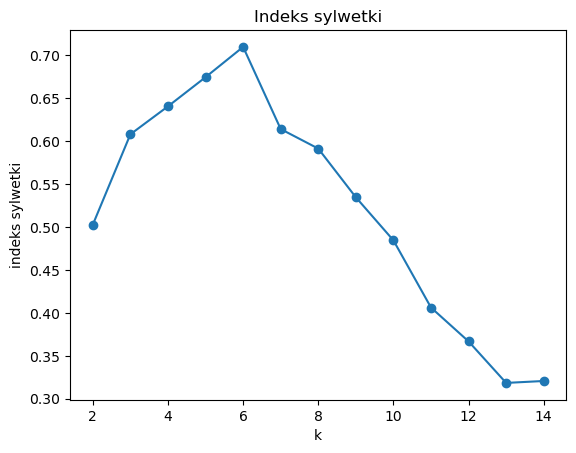

In [156]:
plt.plot(range(2, 15), sil_score2, "-o")
plt.title("Indeks sylwetki")
plt.xlabel("k")
plt.ylabel("indeks sylwetki")
plt.show()

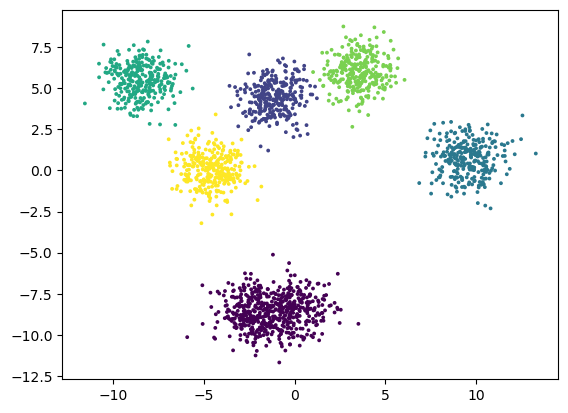

In [157]:
model_kmeans2 = KMeans(n_clusters = 6, n_init = 10, random_state = 7)
model_kmeans2.fit(X)
plt.scatter(X[:,0], X[:,1], c = model_kmeans2.labels_, s = 3)
plt.show()

#### Birch dla pełnych danych, znana liczba klastrów

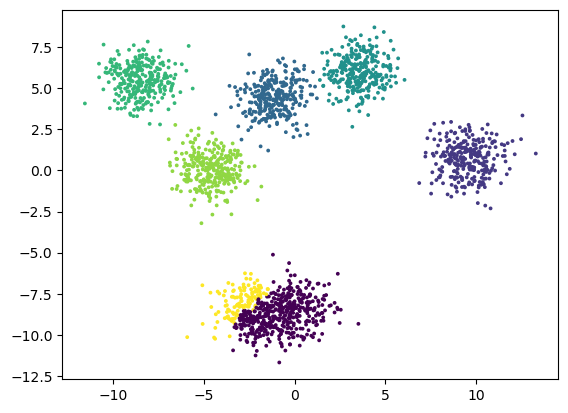

In [158]:
model_birch3 = Birch(n_clusters = 7, threshold = .5) # wishful thinking
model_birch3.fit(X)
plt.scatter(X[:,0], X[:,1], c = model_birch3.labels_, s = 3)
plt.show()

#### Birch z threshold = 5

In [159]:
model_birch4 = Birch(n_clusters = None, threshold = 5)

In [160]:
model_birch4.fit(X)
centers_birch4 = model_birch4.subcluster_centers_
centers_birch4

array([[ 6.55925546,  3.33426455],
       [-4.7270908 ,  3.31289009],
       [-1.21334393, -8.58927799]])

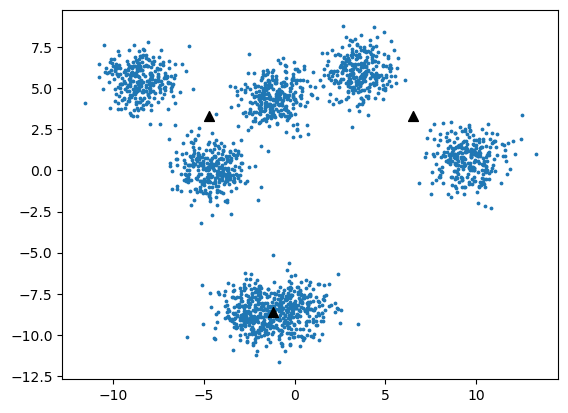

In [161]:
plt.scatter(X[:,0], X[:,1], s = 3)
plt.scatter(centers_birch4[:,0], centers_birch4[:,1], c = "black", marker = "^" , s = 50)
plt.show()

### Ćwiczenie 3: działanie algorytmu BIRCH i grupowania aglomeracyjnego na zbiorze danych blobs

Powtórz analizę dla danych blobs dla klasteryzacji aglomeracyjnej. Zastosuj w pierwszym kroku algorytm BIRCH, a następnie klasteryzację aglomeracyjną. Porównaj wyniki z klasteryzacją aglomeracyjną bez wstępnego grupowania za pomocą BIRCH.

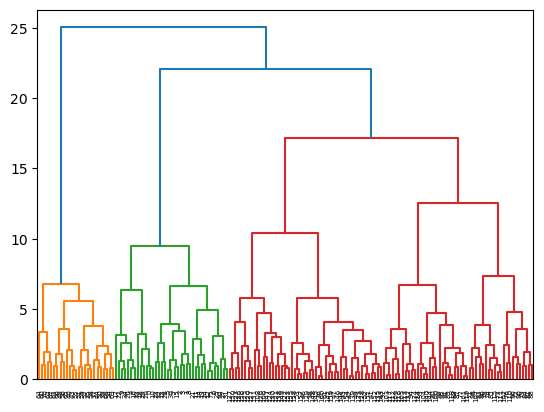

In [162]:
L1 = linkage(Xsmall, method='complete', metric='euclidean')
dendrogram(L1)
plt.show()

In [163]:
clust1 = fcluster(L1, 4, criterion='maxclust')

In [164]:
labels_fin2 = clust1[labels_birch]

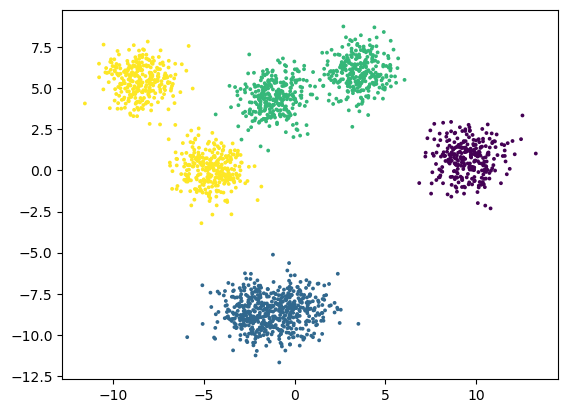

In [165]:
plt.scatter(X[:,0], X[:,1], c= labels_fin2, s = 3)
plt.show()

In [166]:
model_birch5 = Birch(n_clusters = AgglomerativeClustering(n_clusters = 4, linkage = 'complete'))
model_birch5.fit(X)

Birch(n_clusters=AgglomerativeClustering(linkage='complete', n_clusters=4))

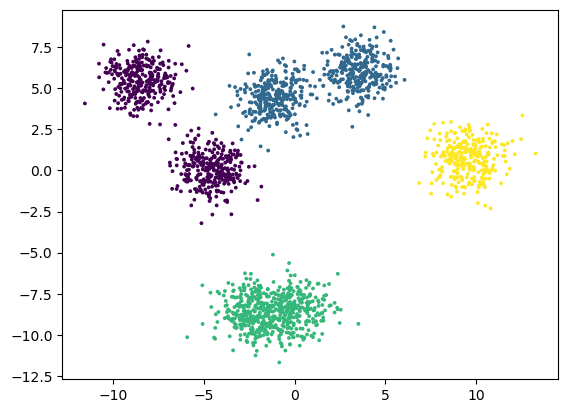

In [167]:
plt.scatter(X[:,0], X[:,1], c = model_birch5.labels_, s = 3)
plt.show()

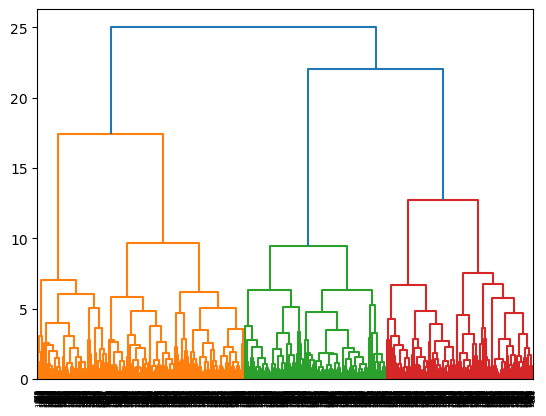

In [168]:
L2 = linkage(X, method='complete', metric='euclidean')
dendrogram(L2)
plt.show()

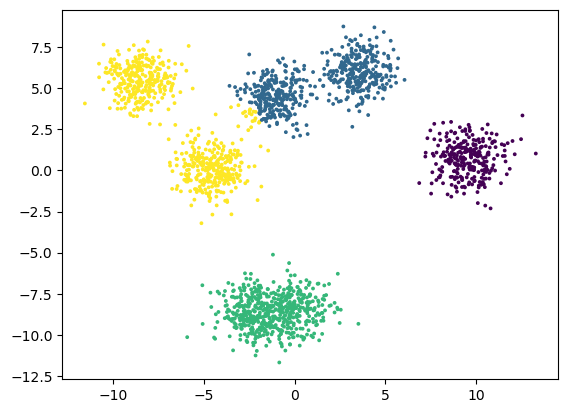

In [169]:
clust2 = fcluster(L2, 4, criterion='maxclust')
plt.scatter(X[:,0], X[:,1], s = 3, c = clust2)
plt.show()

## Grupowanie Mini-Batch K-Means

### Przykład 4: porównanie algorytmów K-Means i Mini-Batch K-Means na danych blobs

Dla danych blobs (jak wyżej) porównaj działanie algorytmów KMeans i Mini-Batch K-Means dla liczby klastrów równej 7: 
    oblicz czasy działania algorytmów i wss znalezionych grupowań. Dla jakiej części obserwacji algorytmy 
    przyporządkowały je do różnych klastrów?

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html

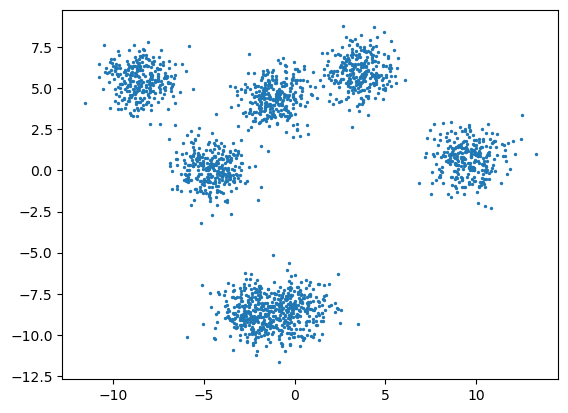

In [170]:
X = make_blobs(n_samples = 2000, centers = 7, random_state = 7)[0]
plt.scatter(X[:,0], X[:,1], s = 2)
plt.show()

Sprawdzenie dla n_init = 10 i n_init = 1! ?

In [177]:
kmeans = KMeans(n_clusters=7, n_init=10, random_state = 13)
t0 = time.time()
kmeans.fit(X)
t_kmeans = time.time() - t0

In [178]:
batch_size = 200
wyniki = pd.DataFrame(columns=[ 'KMeans', 'Mini-Batch K-means'], index = ['czas', 'wss'])
wyniki['KMeans'] = [t_kmeans, kmeans.inertia_]
mbk = MiniBatchKMeans(n_clusters = 7, batch_size = batch_size, n_init = 10, random_state = 13)
t0 = time.time()
mbk.fit(X)
t_mbk = time.time() - t0
wyniki['Mini-Batch K-means'] = [t_mbk, mbk.inertia_]

In [179]:
wyniki

,KMeans,Mini-Batch K-means
czas,0.239822,0.149715
wss,3712.746327,3724.814639


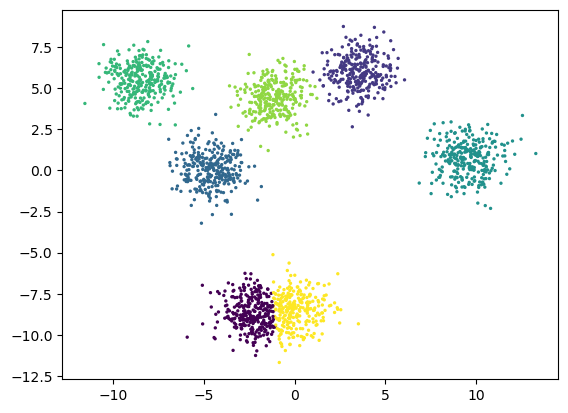

In [180]:
plt.scatter(X[:,0], X[:,1], c = kmeans.labels_, s = 2)
plt.show()

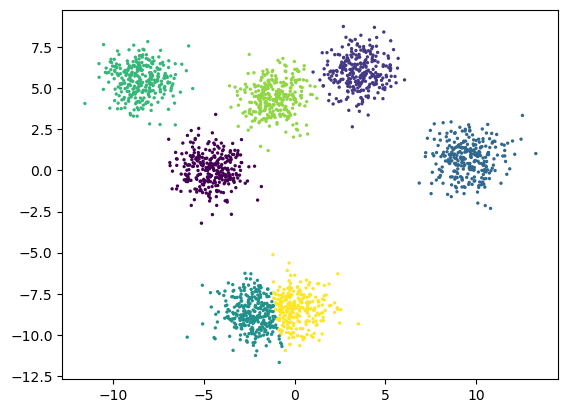

In [181]:
plt.scatter(X[:,0], X[:,1], c = mbk.labels_, s = 2)
plt.show()

In [182]:
print(pd.crosstab(kmeans.labels_, mbk.labels_))

col_0    0    1    2    3    4    5    6
row_0                                   
0        0    0    0  302    0    0    0
1        0  280    0    0    0    0    0
2      286    0    0    0    0    0    0
3        0    0  286    0    0    0    0
4        0    0    0    0  286    0    0
5        0    0    0    0    0  291    0
6        0    0    0   11    0    0  258


In [183]:
11/2000

0.0055

### Ćwiczenie 4: prównanie BIRCH, K-Means i Mini-Batch K-Means

Dla danych blobs z 1 000 000 obserwacji  porównaj działanie algorytmów BIRCH, KMeans i Mini-Batch K-Means dla liczby 
klastrów równej 100: oblicz czasy działania algorytmów i ARI znalezionych grupowań. Dla algorytmu BIRCH wypróbuj dwie 
metody grupowania w drugim kroku: aglomeracyjne z metodą Warda oraz k-średnich.

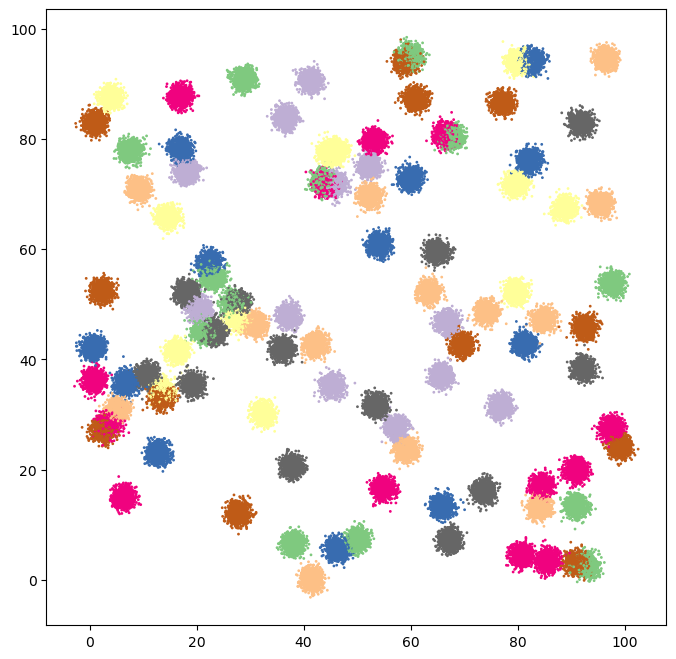

In [200]:
X, labels = make_blobs(100000, centers = 100, center_box=[0,100], random_state=7)
plt.figure(figsize=(8,8))
plt.scatter(X[:,0],X[:,1], s=1, c = labels, cmap = 'Accent')
plt.show()

In [201]:
wyniki = pd.DataFrame(columns=[ 'BIRCH agg ward', 'BIRCH K-Means', 'K-Means', 'Mini-Batch K-Means'], index = ['czas', 'ARI'])
model_birch1 = Birch(n_clusters = AgglomerativeClustering(n_clusters = 100, linkage = 'ward'))
t0 = time.time()
model_birch1.fit(X)
t_birch1 = time.time() - t0
wyniki['BIRCH agg ward'] = [t_birch1, adjusted_rand_score(labels, model_birch1.labels_)]

In [202]:
model_birch2 = Birch(n_clusters = KMeans(100, n_init = 10))
t0 = time.time()
model_birch2.fit(X)
t_birch2 = time.time() - t0
wyniki['BIRCH K-Means'] = [t_birch2, adjusted_rand_score(labels, model_birch2.labels_)]

In [204]:
batch_size = 256*cpu_count()
mbk = MiniBatchKMeans(n_clusters = 100, batch_size = batch_size, n_init = 10, random_state = 7)
t0 = time.time()
mbk.fit(X)
t_mbk = time.time() - t0
wyniki['Mini-Batch K-Means'] = [t_mbk, adjusted_rand_score(labels, mbk.labels_)]

In [205]:
kmeans = KMeans(100, n_init = 10, random_state = 7)
t0 = time.time()
kmeans.fit(X)
t_kmeans = time.time() - t0
wyniki['K-Means'] = [t_kmeans, adjusted_rand_score(labels, kmeans.labels_)]

In [206]:
wyniki

,BIRCH agg ward,BIRCH K-Means,K-Means,Mini-Batch K-Means
czas,10.572741,11.333430,16.677716,0.780032
ARI,0.846267,0.863226,0.886310,0.848877


In [209]:
model_birch = Birch(n_clusters = None) # spr czy trhreshold sensowny...
model_birch.fit(X)

Birch(n_clusters=None)

In [210]:
len(model_birch.subcluster_centers_)

3301

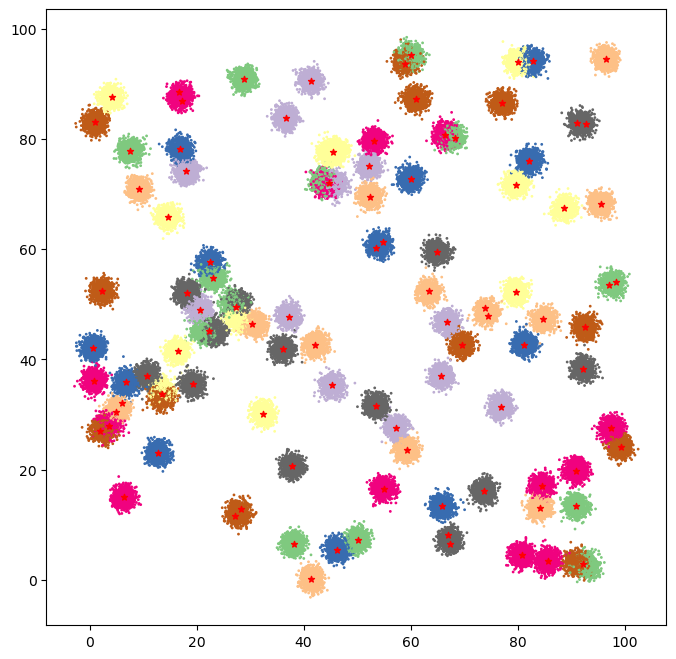

In [207]:
plt.figure(figsize=(8,8))
plt.scatter(X[:,0],X[:,1], s=1, c = labels, cmap = 'Accent')
centers = mbk.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], s=20, c = 'red', marker = '*')
plt.show()

In [199]:
# 10 najmniejszych odleglosci dla losowych 1000 punktow
#odleglosci = pd.DataFrame(np.sort(pairwise_distances(X[np.random.choice(range(len(X)),1000)]))[:,:10])

In [198]:
#odleglosci.describe()

### Ćwiczenie 5: zbiór danych digits

Pogrupuj dane.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html

In [212]:
digits = load_digits()
X = digits.data
y = digits.target

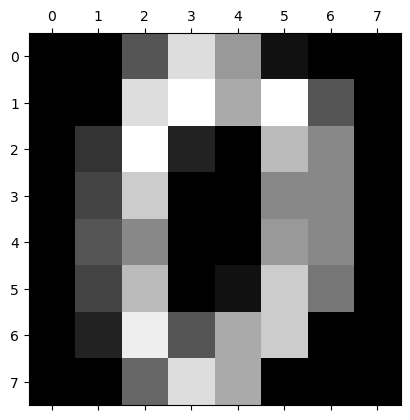

In [213]:
#plt.gray()
plt.matshow(digits.images[0], cmap = 'gray')
plt.show()

In [214]:
pd.DataFrame(digits.data).describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,16.000000,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


In [215]:
X.shape

(1797, 64)

In [216]:
np.bincount(y)

array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180])

In [217]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

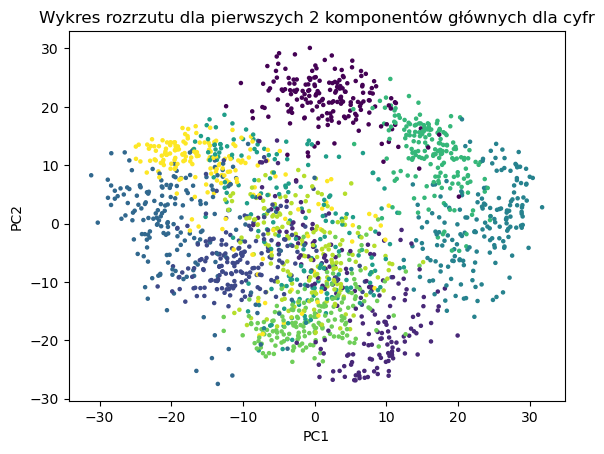

In [218]:
plt.scatter(X_pca[:,0], X_pca[:,1], s = 5, c = y)
plt.title("Wykres rozrzutu dla pierwszych 2 komponentów głównych dla cyfr")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [219]:
wss = []
sil_score = []
for i in range(1, 20):
    model = KMeans(n_clusters = i, n_init = 10, random_state = 7)
    model.fit(X)
    wss.append(model.inertia_)
    if i>1:
        sil_score.append(silhouette_score(X, model.labels_))

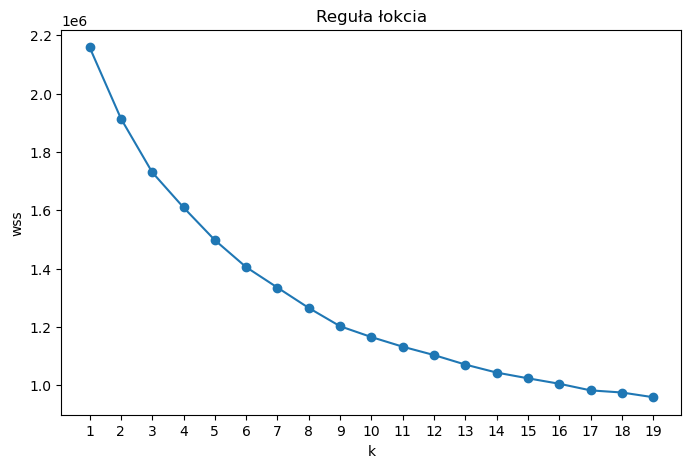

In [220]:
plt.figure(figsize = (8, 5))
plt.plot(range(1, 20), wss, "-o")
plt.xticks (range(1,20))
plt.title("Reguła łokcia")
plt.xlabel("k")
plt.ylabel("wss")
#plt.savefig('lokiec.png')
plt.show()

In [221]:
kl = KneeLocator(range(1, 20), wss, curve="convex", direction="decreasing")
kl.elbow

8

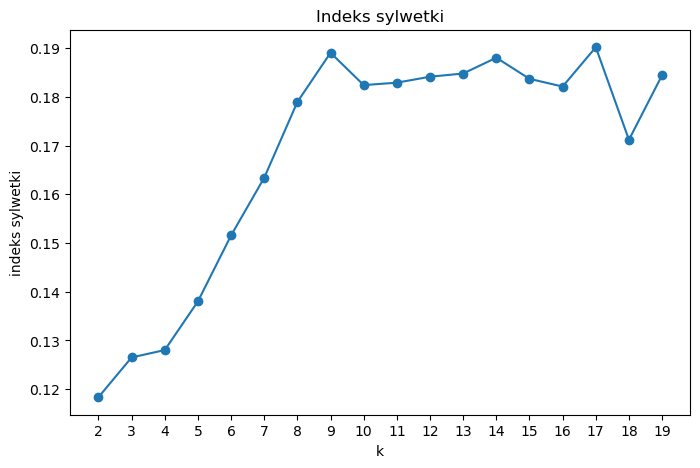

In [222]:
plt.figure(figsize = (8, 5))
plt.plot(range(2, 20), sil_score, "-o")
plt.title("Indeks sylwetki")
plt.xlabel("k")
plt.ylabel("indeks sylwetki")
plt.xticks (range(2,20))
#plt.savefig('sylwetka.png')
plt.show()

In [223]:
model = KMeans(n_clusters = 10, n_init = 10, random_state = 7)
model.fit(X)
labels = model.labels_ 

In [224]:
adjusted_rand_score(labels, y)

0.6673324909505219

In [225]:
print(pd.crosstab(labels, y))

col_0    0   1    2    3    4    5    6    7    8    9
row_0                                                 
0        1   0    0    0  164    2    0    0    0    0
1        0  99    8    7    3    0    2    2  102    2
2        0   1   13  154    0    0    0    0    2    6
3        0   0    2   13    0   43    0    0   51  139
4        0   1    0    2    0  136    0    1    4    6
5        0   2    0    0    0    1  177    0    2    0
6        0   0    3    7    9    0    0  174    5    7
7        0  55    2    0    5    0    1    2    5   20
8      177   0    1    0    0    0    1    0    0    0
9        0  24  148    0    0    0    0    0    3    0


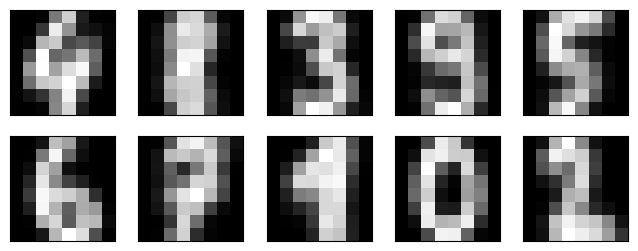

In [226]:
fig, ax = plt.subplots(2, 5, figsize = (8,3))
centers = model.cluster_centers_.reshape(10,8,8) 
for axi, center in zip(ax.flat, centers):
    axi.set(xticks = [], yticks = [])
    axi.imshow(center, cmap = 'gray') # interpolation='nearest', plt.cm.binary

In [68]:
#labels2 = np.zeros_like(labels)
#for i in range(10): 
#    mask = (labels == i) 
#    print(mask)
#    labels[mask] = mode(digits.target[mask])[0]

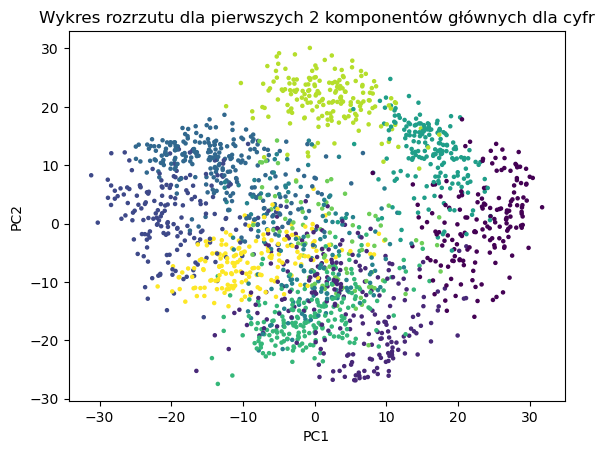

In [228]:
plt.scatter(X_pca[:,0], X_pca[:,1], s = 5, c = labels)
plt.title("Wykres rozrzutu dla pierwszych 2 komponentów głównych dla cyfr")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [229]:
L1 = linkage(X, method='ward', metric='euclidean')

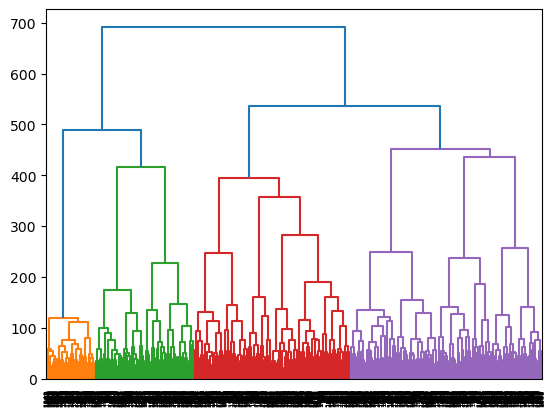

In [77]:
dendrogram(L1)
plt.show()

In [230]:
clust1 = fcluster(L1, 10, criterion='maxclust')

In [231]:
adjusted_rand_score(clust1, y)

0.7940031835568753

In [232]:
print(pd.crosstab(clust1, y))

col_0    0   1    2    3    4    5    6    7    8    9
row_0                                                 
1      178   0    0    0    0    0    0    0    0    0
2        0   0    0    0    0    1  180    0    0    0
3        0   0    0    0  178    0    0    0    0    0
4        0   0    1    1    3    0    0  179    1   11
5        0  59    0    0    0    0    0    0    1   20
6        0  96    0    0    0    0    0    0    2    0
7        0   0   10   13    0    0    1    0  165    2
8        0   0    0  169    0    2    0    0    1  145
9        0  27  166    0    0    0    0    0    4    0
10       0   0    0    0    0  179    0    0    0    2


In [233]:
model_dbscan = DBSCAN().fit(X)
labels_dbscan = model_dbscan.labels_

In [234]:
(labels_dbscan == -1).sum()

1797

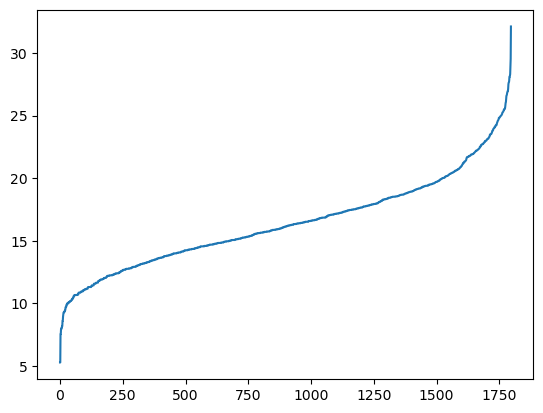

In [235]:
model_knn = NearestNeighbors(n_neighbors = 4).fit(X)
distances = model_knn.kneighbors(X)[0]
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

In [236]:
kl = KneeLocator(range(0, len(distances)), distances, curve="convex", direction="increasing") # , interp_method="polynomial"
kl.elbow

1784

In [237]:
distances[1784]

26.94438717061496

In [238]:
model1 = DBSCAN(eps = 22, min_samples = 4).fit(X)
labels1 = model1.labels_

In [239]:
(labels1 == -1).sum()

205

In [240]:
np.bincount(labels1[labels1 != -1])

array([175, 444, 421, 165, 155, 148,   6,   9,  16,  11,  27,  11,   4])

In [241]:
adjusted_rand_score(labels1, y)

0.5032259370088297

## Źródła:

Hastie, Trevor, et al. The elements of statistical learning: data mining, inference, and prediction. Vol. 2. New York: springer, 2009.

Muller, Andreas, et al. Machine learning, Python i data science, Wprowadzenie. Helion, 2021.

https://en.wikipedia.org/wiki/Rand_index

https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/

https://medium.com/analytics-vidhya/the-ultimate-guide-for-clustering-mixed-data-1eefa0b4743b

https://www.coryjmaklin.com/2019-07-01_Machine-Learning--BIRCH-Clustering-Algorithm-Clearly-Explained-fb9838cbeed9/

https://www.geeksforgeeks.org/ml-mini-batch-k-means-clustering-algorithm/

https://www.kaggle.com/code/ksavleen/handwritten-digit-recognition-kmeans-clustering/notebook
